In [1]:
!pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# loading data
df = pd.read_csv('Data Aggregated.csv')

print("Original Data Head:")
df.head()
print(f"\nOriginal Data Shape: {df.shape}")
print(f"\nOriginal Data Columns: {df.columns.tolist()}")

Original Data Head:

Original Data Shape: (521180, 16)

Original Data Columns: ['Unnamed: 0', 'LSOA code', 'Date', 'LSOA name', 'Ward code', 'Ward name', 'LSOA Area Size (HA)', 'Burglary Count', 'Overall Ranking - IMD', 'Housing rank', 'Health rank', 'Living environment rank', 'Crime rank', 'Education rank', 'Income rank', 'Employment rank']


In [3]:
# data preprocessing
df['Date'] = pd.to_datetime(df['Date'])

df = df.groupby('Date').agg(
        {'Burglary Count': 'sum', 
         'Housing rank': 'mean',
         'Health rank': 'mean',
         'Living environment rank': 'mean',
         'Education rank': 'mean',
         'Income rank': 'mean',
         'Employment rank': 'mean'
        
        }
).reset_index()
print("Shape after further aggregation:", df.shape)

# define COVID period
covid_start_date = pd.to_datetime('2020-03-01')
covid_end_date = pd.to_datetime('2022-05-31') # Adjust as needed

df['is_covid_period'] = ((df['Date'] >= covid_start_date) & (df['Date'] <= covid_end_date)).astype(int)

# Select features for the model
feature_cols = ['Housing rank', 'Health rank', 'Living environment rank', 
                'Education rank', 'Income rank', 'Employment rank'] # the features are reduced as we decided
exog_cols_base = feature_cols # base rank features
exog_cols_full = exog_cols_base + ['is_covid_period'] # All exogenous features


Shape after further aggregation: (171, 8)


In [4]:
# Train Test Split
# Let's say we use the last 12 months for testing.
test_size = 12 # months

train_df = df[:-test_size]
test_df = df[-test_size:]

y_train = train_df['Burglary Count']
X_train = train_df[exog_cols_base] #use exog_cols_full for covid

y_test = test_df['Burglary Count']
X_test = test_df[exog_cols_base]

print(f"\nTraining data shape: y_train {y_train.shape}, X_train {X_train.shape}")
print(f"Test data shape: y_test {y_test.shape}, X_test {X_test.shape}")



Training data shape: y_train (159,), X_train (159, 6)
Test data shape: y_test (12,), X_test (12, 6)


In [5]:
#  4. SARIMAX Model

print("\nRunning auto_arima to find best SARIMAX parameters...")
# Note: auto_arima can be time-consuming for large datasets or complex models.

auto_model = pm.auto_arima(y_train,
                           exogenous=X_train,
                           start_p=0, start_q=0,
                           max_p=3, max_q=3, # Explore up to order 3 for AR and MA
                           d=None,           # Let auto_arima determine 'd'
                           start_P=0, start_Q=0,
                           max_P=2, max_Q=2, # Explore up to order 2 for seasonal AR and MA
                           D=None,           # Let auto_arima determine 'D'
                           m=12,             # Seasonality period (12 for monthly)
                           seasonal=True,    # Enable seasonal component
                           stepwise=True,    # Use stepwise algorithm to speed up
                           suppress_warnings=True,
                           error_action='ignore', # Skip models that fail to fit
                           trace=True)       # Print model summary during search

print("\nAuto ARIMA Summary:")
print(auto_model.summary())
sarimax_order = auto_model.order
sarimax_seasonal_order = auto_model.seasonal_order


print(f"\nSelected SARIMAX order: {sarimax_order}")
print(f"Selected SARIMAX seasonal order: {sarimax_seasonal_order}")

# Initialize and fit the SARIMAX model
model = SARIMAX(y_train,
                exog=X_train,
                order=sarimax_order,
                seasonal_order=sarimax_seasonal_order,
                enforce_stationarity=False, # Let SARIMAX handle differencing
                enforce_invertibility=False)

print("\nFitting SARIMAX model...")


Running auto_arima to find best SARIMAX parameters...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2446.641, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2389.668, Time=0.60 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2403.394, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2444.960, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2439.500, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2387.551, Time=1.59 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.71 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2376.367, Time=1.13 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2403.982, Time=0.34 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=2.69 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2399.869, Time=1.06 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.97 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2381.739, Time=0.57 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=237

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                          Burglary Count   No. Observations:                  159
Model:             SARIMAX(2, 1, 0)x(1, 0, [1, 2], 12)   Log Likelihood                -965.118
Date:                                 Fri, 23 May 2025   AIC                           1954.236
Time:                                         11:02:34   BIC                           1988.920
Sample:                                              0   HQIC                          1968.331
                                                 - 159                                         
Covariance Type:                                   opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Housing rank                3.6511      2.676   

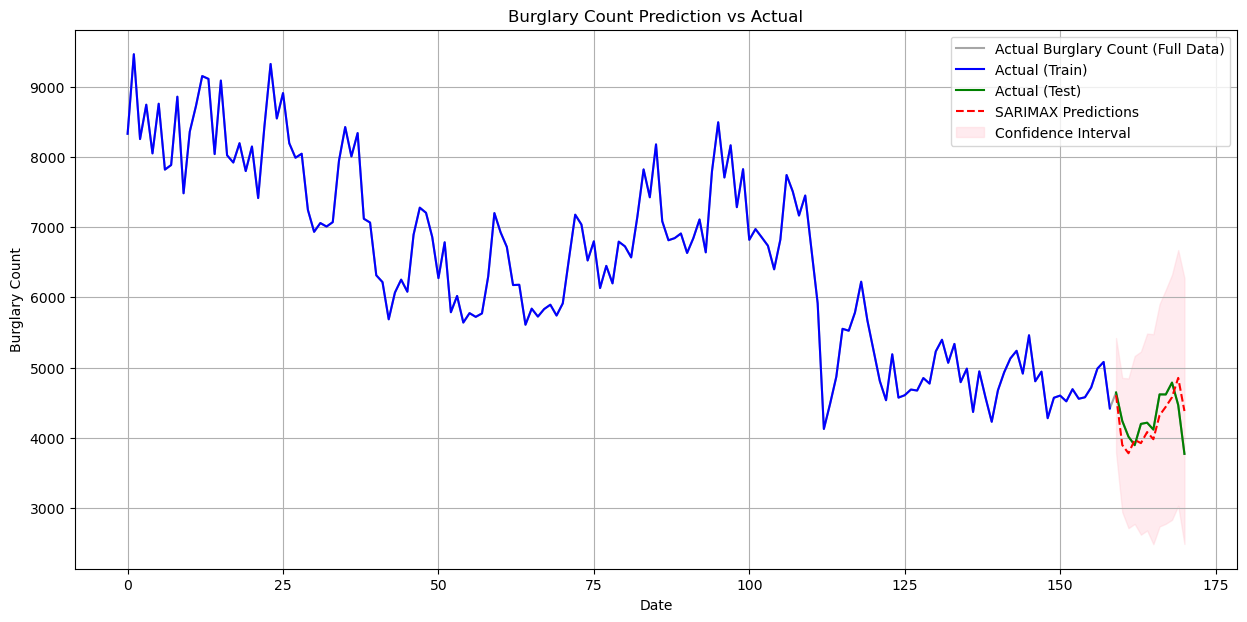

In [6]:

results = model.fit(disp=False) # disp=False to reduce console output
print(results.summary())

# 5. Prediction
# Get predictions for the test period
predictions = results.get_prediction(start=test_df.index[0], 
                                 end=test_df.index[-1], 
                                 exog=X_test)
predicted_mean = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

# 6. Evaluation & Visualization
# Calculate error metrics
rmse = np.sqrt(mean_squared_error(y_test, predicted_mean))
mae = mean_absolute_error(y_test, predicted_mean)
r2 = r2_score(y_test, predicted_mean)
print(f'\nTest RMSE: {rmse:.3f}')
print(f'Test MAE: {mae:.3f}')
print(f'Test R^2: {r2:.3f}')

# Plot
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Burglary Count'], label='Actual Burglary Count (Full Data)', color='gray', alpha=0.7)
plt.plot(y_train.index, y_train, label='Actual (Train)', color='blue')
plt.plot(y_test.index, y_test, label='Actual (Test)', color='green')
plt.plot(predicted_mean.index, predicted_mean, label='SARIMAX Predictions', color='red', linestyle='--')

# Plot confidence intervals
plt.fill_between(confidence_intervals.index,
             confidence_intervals.iloc[:, 0], # lower
             confidence_intervals.iloc[:, 1], # upper
             color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Burglary Count Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Burglary Count')
plt.legend()
plt.grid(True)
plt.show()